In [6]:
import numpy as np
import torch
from tqdm import tqdm
from skmultiflow.data import SEAGenerator
from utils.visualization_utils import plot_train_history
import matplotlib.pyplot as plt
# %matplotlib inline

In [7]:
NUM_OF_ITERATIONS = 200
DRIFT_STEP = 20

In [8]:
stream = SEAGenerator(
    random_state=145,
    balance_classes=False,
    # noise_percentage=0.33
    noise_percentage=0
)

In [9]:
def train_concept_drift_detection(model, stream, num_of_iterations=NUM_OF_ITERATIONS, drift_step=DRIFT_STEP, to_plot=True):
    # optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    metric_history = []

    true_positives = 0
    false_positives = 0
    false_negatives = 0

    drifts = []
    drift_detected = []
    false_drift_detected = []

    is_stream_drifted = False
    last_drift_i = 0
    last_drift_detected_i = 0
    drift_detection_time = []
    for i in tqdm(range(num_of_iterations)):
        x, stream_y_true = stream.next_sample() # TODO: check both with just x and x+y_true
        X = np.concatenate((x, [stream_y_true]), axis=1)

        y_pred_drift = bool(model.predict(X)[0]) # predict if stream is drifted
        metric_history.append(int(is_stream_drifted == y_pred_drift)) # update the metric history
        model.partial_fit(X, [int(is_stream_drifted)]) # tell if stream was drifted


        # stream will be drifted only after previous drift was detected and drift_step steps passed
        if (i - last_drift_detected_i + 1) >= drift_step and is_stream_drifted is False:
            drifts.append(i)
            stream.generate_drift() # y is drifted
            is_stream_drifted = True
            last_drift_i = i
        if is_stream_drifted is False and y_pred_drift is True:
            false_drift_detected.append(i)
            false_positives += 1
        elif is_stream_drifted is True and y_pred_drift is True:
            drift_detection_time.append(i - last_drift_i)
            last_drift_detected_i = i
            drift_detected.append(i)
            is_stream_drifted = False
            true_positives += 1
        elif is_stream_drifted is True and y_pred_drift is False:
            false_negatives += 1


    accuracy = [sum(metric_history[:i]) / len(metric_history[:i]) for i in range(1, num_of_iterations)] # TODO: check precision
    # accuracy = sum(metric_history) / len(metric_history)

    if to_plot:
        num_of_iterations = len(metric_history)
        time = [i for i in range(1, num_of_iterations)]
        plt.plot(time, accuracy, label="Accuracy")
        plt.vlines(x=drifts, color='r', ymin=0., ymax=1., label='Drift', linestyle='--')
        plt.vlines(x=drift_detected, color='g', ymin=0., ymax=1., label='Drift Detected', linestyle='-.')
        plt.vlines(x=false_drift_detected, color='b', ymin=0., ymax=1., label='False Drift Detection', linestyle='-.')
        plt.legend()
        plt.show()

    print(f'last acc: {accuracy[-1]: 0.2f}, avg acc: {np.mean(accuracy): 0.2f}, max acc: {np.max(accuracy): 0.2f}')
    # print(f'last acc: {accuracy: 0.2f}')
    print(f"Precision: {true_positives / (true_positives + false_positives)}; recall: {true_positives / (true_positives + false_negatives)}")
    print(f"Average time needed to detect drift: {sum(drift_detection_time) / len(drift_detection_time)}")


100%|██████████| 200/200 [00:00<00:00, 5910.01it/s]


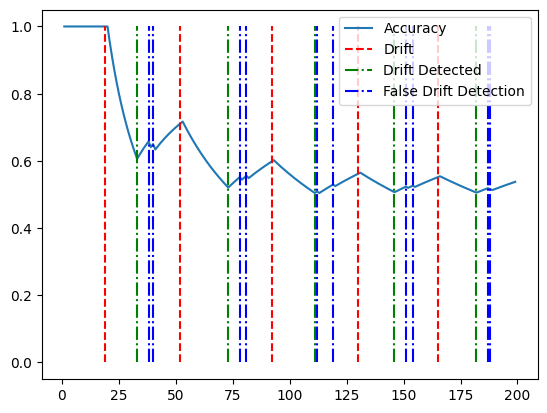

last acc:  0.54, avg acc:  0.62, max acc:  1.00
Precision: 0.3333333333333333; recall: 0.05434782608695652
Average time needed to detect drift: 17.4


In [10]:
from skmultiflow.trees import HoeffdingTreeClassifier

model = HoeffdingTreeClassifier()
train_concept_drift_detection(model, stream, num_of_iterations=200, to_plot=True)